In [108]:
import json
import os
from collections import Counter
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as vutils
from PIL import Image

In [109]:
# The class used for reference
reference_class = 0

# The class used for target clustering
target_class = 1

# The directory to store user assignment
assignment_save_directory = "./kmeans_user_assignment"

# The directory to store kmeans result
kmeans_save_directory = "./kmeans_pickle_save"

# The number of kmeans clusters
n_cluster = 7

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# Target user name, which will be used for image generation
target_username = "f4046_46"

# Size of feature maps in generator
ngf = 64

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# The number of images which will be generated
gen_batch_size = 8

# Spatial size of training images. All images will be resized to this
# size using a transformer.
image_size = 64

In [110]:
# Get cluster assignment for target user

# Load user assignment for reference
with open(os.path.join(assignment_save_directory, "assignment_{}.json".format(reference_class)), "r") as f:
    ref_user_assignment = json.load(f)

# Load target user assignment
with open(os.path.join(assignment_save_directory, "assignment_{}.json".format(target_class)), "r") as f:
    target_user_assignment = json.load(f)

# Check the assignment of the target user in reference clustering results
for cluster_index, user_list in ref_user_assignment.items():
    if target_username in user_list:
        ref_cluster_index = cluster_index
        ref_user_list = user_list
        break

# Build reverse index for target_user_assignment
reverse_assignment_index = {}
for cluster_index, user_list in target_user_assignment.items():
    for username in user_list:
        reverse_assignment_index[username] = cluster_index

# Check each user in the ref_user_list and figure out which cluster they are in
target_cluster_assignment = []
for username in ref_user_list:
    if username == target_username:
        continue

    cur_cluster_index = reverse_assignment_index[username]
    target_cluster_assignment.append(cur_cluster_index)
    
# Count the number of each cluster assignment and 
# choose the max one as the cluster index of the target user
counter = Counter(target_cluster_assignment)
print(counter)
target_cluster_index = sorted(list(counter.items()), key=lambda l: l[1], reverse=True)[0][0]
print("The target user belongs to cluster {} by prediction".format(target_cluster_index))

# The true cluster index of target user
for cluster_index, user_list in target_user_assignment.items():
    if target_username in user_list:
        true_cluster_index = cluster_index
        break
print("The target user belongs to cluster {} in the true result".format(true_cluster_index))

# Print a notification
print("Please train a Generator of cluster {}, class {} before running "
      "the next cell".format(target_cluster_index, target_class))

Counter({'0': 124, '3': 110, '1': 42, '2': 34, '5': 24, '4': 23, '6': 9})
The target user belongs to cluster 0 by prediction
The target user belongs to cluster 0 in the true result
Please train a Generator of cluster 0, class 1 before running the next cell


In [111]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [112]:
generator_read_dir = "./generator_save/{}_{}.pt".format(target_class, target_cluster_index)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Create the generator
netG = Generator(ngpu=ngpu).to(device)
netG.load_state_dict(torch.load(generator_read_dir))
netG.eval()

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

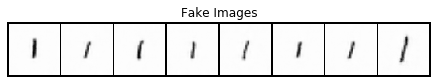

In [113]:
# Create batch of latent vectors that we will use to visualize
# the progression of the generator
fixed_noise = torch.randn(gen_batch_size, nz, 1, 1, device=device)

fake = netG(fixed_noise).detach().cpu()

# Plot the fake images
fig = plt.figure(figsize=(8, (gen_batch_size + 8 - 1) // 8))
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(vutils.make_grid(fake, padding=2, normalize=True), (1,2,0)))
plt.show()

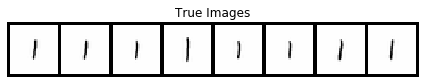

In [114]:
# Display the true image
image_save_dir = "./femnist_by_cluster_{}/{}/all".format(target_class, target_cluster_index)

image_list = []
for file_name in os.listdir(image_save_dir):
    if file_name.startswith(target_username):
        image = Image.open(os.path.join(image_save_dir, file_name))
        image.resize((image_size, image_size))
        image_np = np.asarray(image)
        image_list.append(image_np)

true_images = np.stack(image_list)
true_images = np.expand_dims(true_images, axis=1)

# Plot the true images
fig = plt.figure(figsize=(8, (len(image_list) + 8 - 1) // 8))
plt.axis("off")
plt.title("True Images")
plt.imshow(np.transpose(vutils.make_grid(torch.tensor(true_images / 255), padding=2, normalize=True), (1,2,0)))
plt.show()